# Listing 6-1. Python Implementation of Binary thresholding Method based on Histogram of Pixel Intensities and Otsu's Method 

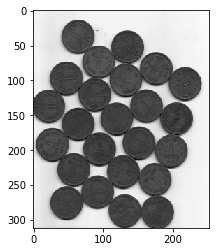

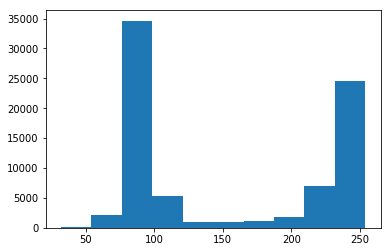

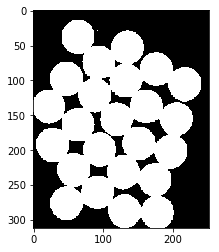

In [19]:
#------------------------------------------------------
# Binary thresholding Method
#------------------------------------------------------

## From the histogram plotted below it's evident that the distribution is bimodal with the lowest probability around
## at around pixel value of 150. Hence 150 would be a good threshold for binary segmentation

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
img = cv2.imread("/home/santanu/Downloads/coins.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.figure(1)
plt.imshow(gray,cmap='gray')
row,col = np.shape(gray)
gray_flat = np.reshape(gray,(row*col,1))[:,0]
plt.figure(2)
plt.hist(list(gray_flat))
gray_const = []
for i in xrange(len(gray_flat)):
    if gray_flat[i] < 150 :
        gray_const.append(255)
    else:
        gray_const.append(0)
gray_const = np.reshape(np.array(gray_const),(row,col))    
plt.figure(3)
plt.imshow(gray_const,cmap='gray')




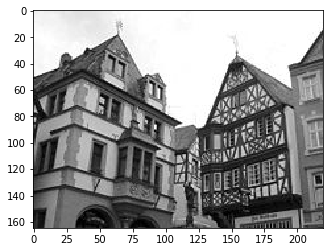

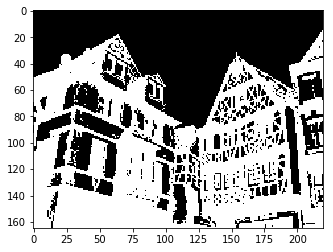

In [7]:
#------------------------------------------------
# Otsu's thresholding Method
#------------------------------------------------
#Otsu's method determines the threshold by maximizing the interclass variance 

img = cv2.imread("/home/santanu/Downloads/otsu.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.figure(1)
plt.imshow(gray,cmap='gray')
row,col = np.shape(gray)
hist_dist = 256*[0]
## Compute the frequency count of each of the pixel in the image
for i in xrange(row):
    for j in xrange(col):
        hist_dist[gray[i,j]] += 1
# Normalize the frequencies to produce probabilities
hist_dist = [c/float(row*col) for c in hist_dist]
## Compute the between segment variance 
def var_c1_c2_func(hist_dist,t):
    u1,u2,p1,p2,u = 0,0,0,0,0
    for i in xrange(t+1):
        u1 += hist_dist[i]*i
        p1 += hist_dist[i]
    for i in xrange(t+1,256): 
        u2 += hist_dist[i]*i
        p2 += hist_dist[i]
    for i in xrange(256):
        u += hist_dist[i]*i
    var_c1_c2 = p1*(u1 - u)**2 + p2*(u2 - u)**2
    return var_c1_c2
## Iteratively run through all the pixel intensities from 0 -255 and chose the one that 
## maximizes the variance 

variance_list = []
for i in xrange(256):
    var_c1_c2 = var_c1_c2_func(hist_dist,i)
    variance_list.append(var_c1_c2)
## Fetch the threshold that maximizes the variance
t_hat = np.argmax(variance_list)
## Compute the segmented image based on the threshold t_hat

gray_recons = np.zeros((row,col))

for i in xrange(row):
    for j in xrange(col):
        if gray[i,j] <= t_hat :
            gray_recons[i,j] = 255
        else:
            gray_recons[i,j] = 0
plt.figure(2)
plt.imshow(gray_recons,cmap='gray') 


# Listing 6-2. Image Segmentation using Watershed Algorithm 

[INFO] 24 unique segments found


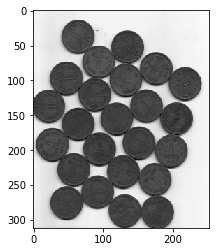

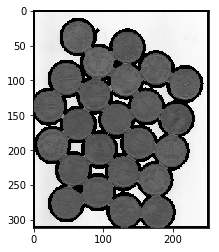

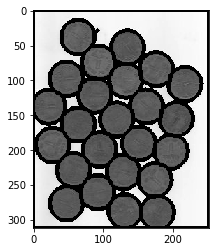

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
## Load the coins image
img = cv2.imread("/home/santanu/Downloads/coins.jpg")
## Convert the image to gray scale
imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.figure(1)
plt.imshow(imgray,cmap='gray')
# Threshold the image to convert it to Binary image based on Otsu's method
thresh = cv2.threshold(imgray, 0, 255,
cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

## Detect the contours and display them
## As we can see in the 2nd image below that the contours are not prominent at the regions of
## overlap with normal thresholding method. However with Wateshed algorithm the 
## the same is possible because of its ability to better separate regions of overlap by
## building watersheds at the boundaries of different basins of pixel intensity minima

im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
y = cv2.drawContours(imgray, contours, -1, (0,255,0), 3)
plt.figure(2)
plt.imshow(y,cmap='gray')
## Hence we will proceed with the Watershed algorithm so that each of the coin form its own
## cluster and hence its possible to have separate contours for each coin.
## Relabel the thresholded image to be consisting of only 0 and 1
## as the input image to distance_transform_edt should be in this format.
thresh[thresh == 255] = 5
thresh[thresh == 0] = 1
thresh[thresh == 5] = 0
## The distance_transform_edt and the peak_local_max functions helps building the markers by detecting
## points near the centre points of the coins. One can skip these steps and create a marker
## manually by setting one pixel within each coin with a random number represneting its cluster
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=10,
labels=thresh)
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
# Provide the EDT distance matrix and the markers to the watershed algorithm to detect the clusters
# labels for each pixel. For each coin, the pixels corresponding to it will be filled with the cluster number
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))
#Create the contours for each label(each coin and append to the plot)
for k in np.unique(labels):
    if k != 0 :
        labels_new = labels.copy()
        labels_new[labels == k] = 255
        labels_new[labels != k] = 0
        labels_new = np.array(labels_new,dtype='uint8')
        im2, contours, hierarchy = cv2.findContours(labels_new,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        z = cv2.drawContours(imgray,contours, -1, (0,255,0), 3)
        plt.figure(3)
        plt.imshow(z,cmap='gray') 

# Listing 6-3.Image Segmentation using K-means 

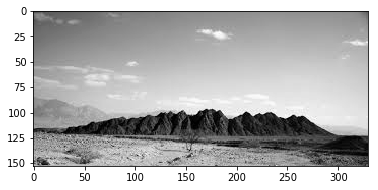

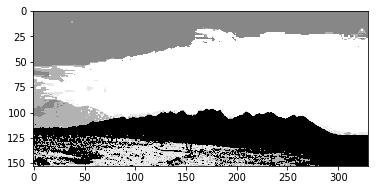

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#np.random.seed(0)
#----------------------------------------------
# K means that one has used in Machine learning 
# clustering also provides good segmentation as we see below
#----------------------------------------------
img = cv2.imread("kmeans1.jfif")
imgray_ori = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.figure(1)
plt.imshow(imgray_ori,cmap='gray')
## Save the dimensions of the image
row,col,depth = img.shape
## Collapse the row and column axis for faster matrix operation.
img_new = np.zeros(shape=(row*col,3))
glob_ind = 0 
for i in xrange(row):
    for j in xrange(col):
        u = np.array([img[i,j,0],img[i,j,1],img[i,j,2]]) 
        img_new[glob_ind,:] = u
        glob_ind += 1

#--------------------------------------------------------
# Set the number of clusters
# One can experiment with different values of K and select 
# the one that provides good clustering. Having said that Image processing
# especially image enhancement and segmentation to some extent is subjective.
#--------------------------------------------------------
K = 5
#-------------------------------------------------------------------
# K means suffers from local minima solution and hence 
# its better to trigger K-means several times with different random seed value
#--------------------------------------------------------------------
num_iter = 20
for g in xrange(num_iter):
    # Define cluster for storing the cluster number and out_dist to store the distances from centroid
    clusters = np.zeros((row*col,1))
    out_dist = np.zeros((row*col,K))
    centroids = np.random.randint(0,255,size=(K,3))

    for k in xrange(K):
        diff = img_new - centroids[k,:]
        diff_dist = np.linalg.norm(diff,axis=1)
        out_dist[:,k] = diff_dist

# Assign the cluster with minimum distance to a pixel location

    clusters = np.argmin(out_dist,axis=1)

# Recompute the clusters

    for k1 in np.unique(clusters):
        centroids[k1,:] = np.sum(img_new[clusters == k1,:],axis=0)/np.sum([clusters == k1])

# Reshape the cluster labels in two dimensional image form
clusters = np.reshape(clusters,(row,col))
out_image = np.zeros(img.shape)

#Form the 3-D image with the labels replaced by their correponding centroid pixel intensity

for i in xrange(row):
    for j in xrange(col):
        out_image[i,j,0] = centroids[clusters[i,j],0]
        out_image[i,j,1] = centroids[clusters[i,j],1]
        out_image[i,j,2] = centroids[clusters[i,j],2]
        out_image = np.array(out_image,dtype="uint8")

# Display the output image after converting into gray scale
# Readers adviced to display the image as it is for better clarity
imgray = cv2.cvtColor(out_image,cv2.COLOR_BGR2GRAY)
plt.figure(2)
plt.imshow(imgray,cmap='gray') 

# Listing 6-4.Semantic Segmentation in TensorFlow with Fully Connected Neural Network 

In [8]:
#-----------------------------------------------
# Load the different packages 
#-----------------------------------------------

import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import os
from subprocess import check_output
import numpy as np
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from scipy.misc import imresize


height,width=128,128
data_dir = "/home/santanu/Downloads/Carvana/train/"
mask_dir = "/home/santanu/Downloads/Carvana/train_masks/"



#---------------------------------------------------------
# Define the feed forward forward network.
# Fully Connected Convolutional Network inspited by the U-Net
# Architecture
#---------------------------------------------------------
x = tf.placeholder(tf.float32,[None,height,width,3])
y = tf.placeholder(tf.float32,[None,height,height,1])

def down_sample(x,w1,b1,w2,b2,pool=True):
    x = tf.nn.conv2d(x,w1,strides=[1,1,1,1],padding='SAME')
    x = tf.nn.bias_add(x,b1)
    x = tf.nn.relu(x)
    x = tf.nn.conv2d(x,w2,strides=[1,1,1,1],padding='SAME')
    x = tf.nn.bias_add(x,b2)
    x = tf.nn.relu(x)
    if pool:
        y = tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')  
        return y,x
    else:
        return x
    

def up_sample(x,w,b):
    output_shape  = x.get_shape().as_list()
    output_shape[0] = 4
    output_shape[1] *= 2
    output_shape[2] *= 2
    output_shape[1] = np.int(output_shape[1])
    output_shape[2] = np.int(output_shape[2])
    output_shape[3] = w.get_shape().as_list()[2]
    conv_tf = tf.nn.conv2d_transpose(value=x,filter=w,output_shape=output_shape,strides=[1,2,2,1],padding="SAME")
    conv_tf = tf.nn.bias_add(conv_tf,b)
    return tf.nn.relu(conv_tf)



#---------------------------------------------------------
# Define weights and biases
#---------------------------------------------------------

weights = {
    'w11': tf.Variable(tf.random_normal([3,3,3,64],mean=0.0,stddev=0.02),name='w11'),
    'w12': tf.Variable(tf.random_normal([3,3,64,64],mean=0.0,stddev=0.02),name='w12'),
    'w21': tf.Variable(tf.random_normal([3,3,64,128],mean=0.0,stddev=0.02),name='w21'),
    'w22': tf.Variable(tf.random_normal([3,3,128,128],mean=0.0,stddev=0.02),name='w22'),
    'w31': tf.Variable(tf.random_normal([3,3,128,256],mean=0.0,stddev=0.02),name='w31'),
    'w32': tf.Variable(tf.random_normal([3,3,256,256],mean=0.0,stddev=0.02),name='w32'),
    'w41': tf.Variable(tf.random_normal([3,3,256,512],mean=0.0,stddev=0.02),name='w41'),
    'w42': tf.Variable(tf.random_normal([3,3,512,512],mean=0.0,stddev=0.02),name='w42'),
    'w51': tf.Variable(tf.random_normal([3,3,512,1024],mean=0.0,stddev=0.02),name='w51'),
    'w52': tf.Variable(tf.random_normal([3,3,1024,1024],mean=0.0,stddev=0.02),name='w52'),
    'wu1': tf.Variable(tf.random_normal([3,3,1024,1024],mean=0.0,stddev=0.02),name='wu1'),
    'wu2': tf.Variable(tf.random_normal([3,3,512,1024],mean=0.0,stddev=0.02),name='wu2'),
    'wu3': tf.Variable(tf.random_normal([3,3,256,512],mean=0.0,stddev=0.02),name='wu3'),
    'wu4': tf.Variable(tf.random_normal([3,3,128,256],mean=0.0,stddev=0.02),name='wu4'),
    'wf': tf.Variable(tf.random_normal([1,1,128,1],mean=0.0,stddev=0.02),name='wf')
}
    
    

biases = {
    'b11': tf.Variable(tf.random_normal([64],mean=0.0,stddev=0.02),name='b11'),
    'b12': tf.Variable(tf.random_normal([64],mean=0.0,stddev=0.02),name='b12'),
    'b21': tf.Variable(tf.random_normal([128],mean=0.0,stddev=0.02),name='b21'),
    'b22': tf.Variable(tf.random_normal([128],mean=0.0,stddev=0.02),name='b22'),
    'b31': tf.Variable(tf.random_normal([256],mean=0.0,stddev=0.02),name='b31'),
    'b32': tf.Variable(tf.random_normal([256],mean=0.0,stddev=0.02),name='b32'),
    'b41': tf.Variable(tf.random_normal([512],mean=0.0,stddev=0.02),name='b41'),
    'b42': tf.Variable(tf.random_normal([512],mean=0.0,stddev=0.02),name='b42'),
    'b51': tf.Variable(tf.random_normal([1024],mean=0.0,stddev=0.02),name='b51'),
    'b52': tf.Variable(tf.random_normal([1024],mean=0.0,stddev=0.02),name='b52'),
    'bu1': tf.Variable(tf.random_normal([1024],mean=0.0,stddev=0.02),name='bu1'),
    'bu2': tf.Variable(tf.random_normal([512],mean=0.0,stddev=0.02),name='bu2'),
    'bu3': tf.Variable(tf.random_normal([256],mean=0.0,stddev=0.02),name='bu3'),
    'bu4': tf.Variable(tf.random_normal([128],mean=0.0,stddev=0.02),name='bu4'),
    'bf': tf.Variable(tf.random_normal([1],mean=0.0,stddev=0.02),name='bf')
    
}

## Create the final model 

def unet_basic(x,weights,biases,dropout=1):
    
    ## Convolutional 1
    out1,res1 = down_sample(x,weights['w11'],biases['b11'],weights['w12'],biases['b12'],pool=True)
    out1,res1 = down_sample(out1,weights['w21'],biases['b21'],weights['w22'],biases['b22'],pool=True)
    out1,res1 = down_sample(out1,weights['w31'],biases['b31'],weights['w32'],biases['b32'],pool=True)
    out1,res1 = down_sample(out1,weights['w41'],biases['b41'],weights['w42'],biases['b42'],pool=True)
    out1      = down_sample(out1,weights['w51'],biases['b51'],weights['w52'],biases['b52'],pool=False)
    up1       = up_sample(out1,weights['wu1'],biases['bu1'])
    up1       = up_sample(up1,weights['wu2'],biases['bu2'])  
    up1       = up_sample(up1,weights['wu3'],biases['bu3'])  
    up1       = up_sample(up1,weights['wu4'],biases['bu4'])
    out       = tf.nn.conv2d(up1,weights['wf'],strides=[1,1,1,1],padding='SAME')
    out       = tf.nn.bias_add(out,biases['bf'])
    #out       = tf.nn.sigmoid(out)
    return out    
 
    
#----------------------------------------------------------------------
# Since its hard to fit all images into memory creating batch generators
# is very beneficial
# -------------------------------------------------------------------------

# utility function to convert greyscale images to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img


# generator that we will use to read the data from the directory
def data_gen_small(data_dir, mask_dir, images, batch_size, dims):
        
        
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in ix:
                # images
                original_img = load_img(data_dir + images[i])
                resized_img = imresize(original_img, dims+[3])
                array_img = img_to_array(resized_img)/255
                imgs.append(array_img)
                
                # masks
                original_mask = load_img(mask_dir + images[i].split(".")[0] + '_mask.gif')
                resized_mask = imresize(original_mask, dims+[3])
                array_mask = img_to_array(resized_mask)/255
                labels.append(array_mask[:, :, 0])
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels.reshape(-1, dims[0], dims[1], 1)

# get the path to all images for dynamic fetch in each batch generation
all_images = os.listdir(data_dir)
# pick which images we will use for testing and which for validation
train_images, validation_images = train_test_split(all_images, train_size=0.8, test_size=0.2)
train_gen = data_gen_small(data_dir, mask_dir, train_images,4, [height,width])
validation_gen = data_gen_small(data_dir, mask_dir, validation_images,4, [height,width])


#---------------------------------------------
# Define the final set of ops including cost and optimizer 
#---------------------------------------------
learning_rate=0.0001
keep_prob = tf.placeholder(tf.float32)
logits = unet_basic(x,weights,biases)
prob = tf.nn.sigmoid(logits,name='prob')
flat_logits = tf.reshape(tensor=logits, shape=(-1, 1))
flat_labels = tf.reshape(tensor=y,shape=(-1, 1))
cross_entropies = tf.nn.sigmoid_cross_entropy_with_logits(logits=flat_logits,
                                                          labels=flat_labels)
cost = tf.reduce_mean(cross_entropies)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
init = tf.global_variables_initializer()

## Launch the execution Graph

with tf.Session() as sess:
    sess.run(init)
    for batch in xrange(500):
        batch_x,batch_y= next(train_gen)
        sess.run(optimizer, feed_dict={x:batch_x,y:batch_y})
        loss = sess.run([cost],feed_dict={x:batch_x,y:batch_y})
        ## Validation loss and store the result for display at the end
        val_x,val_y = next(validation_gen)
        loss_val = sess.run([cost],feed_dict={x:val_x,y:val_y})
        out_x = sess.run(prob,feed_dict={x:val_x})
        print('batch:',batch,'train loss:',loss,'validation loss:',loss_val)

('batch:', 0, 'train loss:', [0.69559169], 'validation loss:', [0.69587499])
('batch:', 1, 'train loss:', [0.69544131], 'validation loss:', [0.69517303])
('batch:', 2, 'train loss:', [0.69484985], 'validation loss:', [0.69468892])
('batch:', 3, 'train loss:', [0.69409049], 'validation loss:', [0.69418991])
('batch:', 4, 'train loss:', [0.69315994], 'validation loss:', [0.69314665])
('batch:', 5, 'train loss:', [0.69171995], 'validation loss:', [0.69203711])
('batch:', 6, 'train loss:', [0.68870687], 'validation loss:', [0.68872976])
('batch:', 7, 'train loss:', [0.68513107], 'validation loss:', [0.68557358])
('batch:', 8, 'train loss:', [0.67544252], 'validation loss:', [0.67962122])
('batch:', 9, 'train loss:', [0.6679849], 'validation loss:', [0.67101383])
('batch:', 10, 'train loss:', [0.65122902], 'validation loss:', [0.64307421])
('batch:', 11, 'train loss:', [0.62042731], 'validation loss:', [0.60989881])
('batch:', 12, 'train loss:', [0.61818415], 'validation loss:', [0.66353023

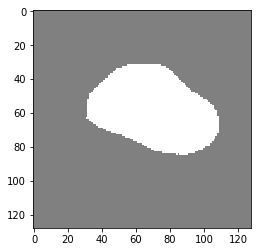

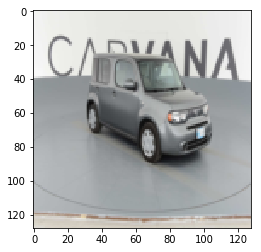

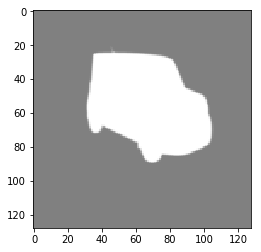

In [9]:
# Validating results 
# Ist image - Output segmented image
# 2nd image - Original image
# 3rd image - Ground truth
img = (out_x[1] > 0.5)*1.0
plt.figure(1)
plt.imshow(grey2rgb(img),alpha=0.5)
plt.figure(2)
plt.imshow(val_x[1])
plt.figure(3)
plt.imshow(grey2rgb(val_y[1]), alpha=0.5)


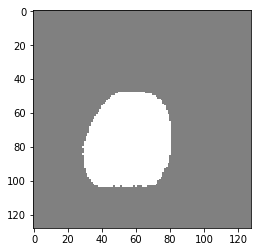

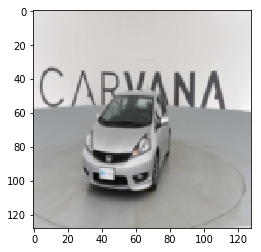

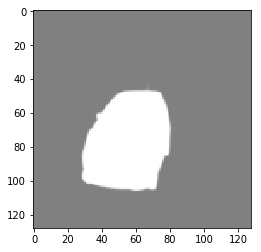

In [10]:
img = (out_x[2] > 0.5)*1.0
plt.figure(4)
plt.imshow(grey2rgb(img),alpha=0.5)
plt.figure(5)
plt.imshow(val_x[2])
plt.figure(6)
plt.imshow(grey2rgb(val_y[2]), alpha=0.5) 

# Listing 6-5. Implementation of a Generative Adversarial Network 

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
('iter:', 2000, 'cost of discriminator', 0.38259384, 'cost of generator', 2.3932228)
('iter:', 3000, 'cost of discriminator', 0.66142315, 'cost of generator', 2.1125033)
('iter:', 4000, 'cost of discriminator', 0.68948466, 'cost of generator', 2.1218815)
('iter:', 5000, 'cost of discriminator', 0.73834038, 'cost of generator', 1.9877869)
('iter:', 6000, 'cost of discriminator', 0.5391584, 'cost of generator', 2.0590949)
('iter:', 7000, 'cost of discriminator', 0.6887902, 'cost of generator', 2.1614187)
('iter:', 8000, 'cost of discriminator', 0.67013669, 'cost of generator', 1.8893187)
('iter:', 9000, 'cost of discriminator', 0.63766521, 'cost of generator', 2.0827096)
('iter:', 10000, 'cost of discriminator', 0.7111268, 'cost of generator', 1.9432487)
('iter:', 11000, 'cost of discriminator', 0

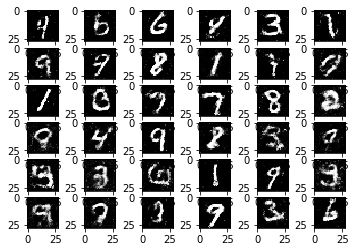

In [8]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## The dimension of the Prior Noise Signal is 100 
## The generator would have 150 and 300 hidden units successively before 784 outputs corresponding
## to 28x28 image size

h1_dim = 150
h2_dim = 300
dim = 100
batch_size = 256

#-------------------------------------------------------------
# Define the generator - take noise and convert them to images
#--------------------------------------------------------------
def generator_(z_noise):
    w1 = tf.Variable(tf.truncated_normal([dim,h1_dim], stddev=0.1), name="w1_g", dtype=tf.float32)
    b1 = tf.Variable(tf.zeros([h1_dim]), name="b1_g", dtype=tf.float32)
    h1 = tf.nn.relu(tf.matmul(z_noise, w1) + b1)
    w2 = tf.Variable(tf.truncated_normal([h1_dim,h2_dim], stddev=0.1), name="w2_g", dtype=tf.float32)
    b2 = tf.Variable(tf.zeros([h2_dim]), name="b2_g", dtype=tf.float32)
    h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)
    w3 = tf.Variable(tf.truncated_normal([h2_dim,28*28],stddev=0.1), name="w3_g", dtype=tf.float32)
    b3 = tf.Variable(tf.zeros([28*28]), name="b3_g", dtype=tf.float32)
    h3 = tf.matmul(h2, w3) + b3
    out_gen = tf.nn.tanh(h3)
    weights_g = [w1, b1, w2, b2, w3, b3]
    return out_gen,weights_g

#-------------------------------------------------------------------------
# Define the Discriminator - take both real images  and synthetic fake images 
# from Generator and classify the real and fake images properly
#---------------------------------------------------------------------------
def discriminator_(x,out_gen,keep_prob):
    x_all = tf.concat([x,out_gen], 0)
    w1 = tf.Variable(tf.truncated_normal([28*28, h2_dim], stddev=0.1), name="w1_d", dtype=tf.float32)
    b1 = tf.Variable(tf.zeros([h2_dim]), name="b1_d", dtype=tf.float32)
    h1 = tf.nn.dropout(tf.nn.relu(tf.matmul(x_all, w1) + b1), keep_prob)
    w2 = tf.Variable(tf.truncated_normal([h2_dim, h1_dim], stddev=0.1), name="w2_d", dtype=tf.float32)
    b2 = tf.Variable(tf.zeros([h1_dim]), name="b2_d", dtype=tf.float32)
    h2 = tf.nn.dropout(tf.nn.relu(tf.matmul(h1,w2) + b2), keep_prob)
    w3 = tf.Variable(tf.truncated_normal([h1_dim, 1], stddev=0.1), name="w3_d", dtype=tf.float32)
    b3 = tf.Variable(tf.zeros([1]), name="d_b3", dtype=tf.float32)
    h3 = tf.matmul(h2, w3) + b3
    y_data = tf.nn.sigmoid(tf.slice(h3, [0, 0], [batch_size, -1], name=None))
    y_fake = tf.nn.sigmoid(tf.slice(h3, [batch_size, 0], [-1, -1], name=None))
    weights_d = [w1, b1, w2, b2, w3, b3]
    return y_data,y_fake,weights_d



# Read the MNIST datadet
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
## Place holder for the real images
x = tf.placeholder(tf.float32, [batch_size, 28*28], name="x_data")
## Place holder for the noise
z_noise = tf.placeholder(tf.float32, [batch_size,dim], name="z_prior")
## Dropout probability
keep_prob = tf.placeholder(tf.float32, name="keep_prob")
# generate the output op for generator and also define the weights.
out_gen,weights_g = generator_(z_noise)
# Define the ops and weights for Discriminator
y_data, y_fake,weights_d = discriminator_(x,out_gen,keep_prob)
## Cost function for Discriminator
discr_loss = -1*tf.reduce_mean(tf.log(y_data) + tf.log(1 - y_fake))
## Cost function for Generator
gen_loss = -1*tf.reduce_mean( tf.log(y_fake))
optimizer = tf.train.AdamOptimizer(0.0001)
d_trainer = optimizer.minimize(discr_loss,var_list=weights_d)
g_trainer = optimizer.minimize(gen_loss,var_list=weights_g)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

sess = tf.Session()
sess.run(init)
z_sample = np.random.uniform(-1, 1, size=(batch_size,dim)).astype(np.float32)

for i in range(60000):
    batch_x, _ = mnist.train.next_batch(batch_size)
    x_value = 2*batch_x.astype(np.float32) - 1
    z_value = np.random.uniform(-1, 1, size=(batch_size,dim)).astype(np.float32)
    sess.run(d_trainer,feed_dict={x:x_value, z_noise:z_value,keep_prob:0.7})
    sess.run(g_trainer,feed_dict={x:x_value, z_noise:z_value,keep_prob:0.7})
    if (i % 1000 == 0) and(i > 1000):
        c1,c2 = sess.run([discr_loss,gen_loss],feed_dict={x:x_value, z_noise:z_value,keep_prob:0.7})
        print ('iter:',i,'cost of discriminator',c1, 'cost of generator',c2)
out_val_img = sess.run(out_gen,feed_dict={z_noise:z_sample})     
img = 0.5*(out_val_img[3,:] + 1)
img = np.reshape(img,(28,28))
plt.imshow(img*255)
saver.save(sess, "newgan_",global_step=i)
imgs = 0.5*(out_val_img + 1)
for k in range(36):
    plt.subplot(6,6,k+1)
    image = np.reshape(imgs[k],(28,28))
    plt.imshow(image,cmap='gray')
   

 
        


# Listing 6-6a Illustration of how to save a Model in TensorFlow 

In [1]:
# -*- coding: utf-8 -*-
import tensorflow as tf 
from tensorflow.examples.tutorials.mnist import input_data


batch_size,learning_rate = 256,0.001
epochs = 10
total_iter = 1000

x = tf.placeholder(tf.float32,[None,784],name='x')
y = tf.placeholder(tf.float32,[None,10],name='y')

W = tf.Variable(tf.random_normal([784,10],mean=0,stddev=0.02),name='W')
b = tf.Variable(tf.random_normal([10],mean=0,stddev=0.02),name='b')
logits = tf.add(tf.matmul(x,W),b,name='logits')
pred = tf.nn.softmax(logits,name='pred')
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(pred,1),name='correct_prediction')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name='accuracy')

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
batches = (mnist.train.num_examples//batch_size)
saver = tf.train.Saver()

cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=y))
optimizer_ = tf.train.AdamOptimizer(learning_rate).minimize(cost)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for step in range(total_iter):
        batch_x,batch_y = mnist.train.next_batch(batch_size)
        sess.run(optimizer_,feed_dict={x:batch_x,y:batch_y})
        c = sess.run(cost,feed_dict={x:batch_x,y:batch_y})
        print ('Loss in iteration ' + str(step) + '= ' + str(c))
        if step % 100 == 0 :
            saver.save(sess,'/home/santanu/model_basic',global_step=step)
    saver.save(sess,'/home/santanu/model_basic',global_step=step)
    val_x,val_y = mnist.test.next_batch(batch_size)        
    print('Accuracy:',sess.run(accuracy,feed_dict={x:val_x,y:val_y}))        


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Loss in iteration 0= 0.649692
Loss in iteration 1= 0.607954
Loss in iteration 2= 0.579626
Loss in iteration 3= 0.549072
Loss in iteration 4= 0.503963
Loss in iteration 5= 0.488077
Loss in iteration 6= 0.491193
Loss in iteration 7= 0.460854
Loss in iteration 8= 0.458596
Loss in iteration 9= 0.448918
Loss in iteration 10= 0.418409
Loss in iteration 11= 0.385886
Loss in iteration 12= 0.392543
Loss in iteration 13= 0.371666
Loss in iteration 14= 0.362706
Loss in iteration 15= 0.363439
Loss in iteration 16= 0.368621
Loss in iteration 17= 0.3472
Loss in iteration 18= 0.341457
Loss in iteration 19= 0.3409
Loss in iteration 20= 0.339263
Loss in iteration 21= 0.332729
Loss in iteration 22= 0.332108
Loss in iteration 23= 0.327881
Loss in iteration 24= 0.328739
Loss in iteration 25= 0.323072
Loss in iterat

# Listing 6-6b Illustration of restoring a saved Model in TensorFlow 

In [2]:
batch_size = 256
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    new_saver = tf.train.import_meta_graph('/home/santanu/model_basic-999.meta')
    new_saver.restore(sess,tf.train.latest_checkpoint('./'))
    graph = tf.get_default_graph()
    pred = graph.get_tensor_by_name("pred:0")
    accuracy = graph.get_tensor_by_name("accuracy:0")
    x = graph.get_tensor_by_name("x:0")
    y = graph.get_tensor_by_name("y:0")
    val_x,val_y = mnist.test.next_batch(batch_size)
    pred_out = sess.run(pred,feed_dict={x:val_x})
    accuracy_out = sess.run(accuracy,feed_dict={x:val_x,y:val_y})           
    print 'Accuracy on Test dataset:',accuracy_out         

Accuracy on Test dataset: 0.867188
